<a href="https://colab.research.google.com/github/bilmark0/Deep-Learning-alpjai-Main-Project/blob/main/deepl_bp_hip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install kaggle library if necessary
!pip install kaggle

In [ ]:
from google.colab import files
import zipfile
import os
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import random
import cv2

In [ ]:
# Ask the user to upload their kaggle.json file
uploaded = files.upload()

# Move the uploaded kaggle.json file to the proper directory
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (1).json


In [ ]:
# Download the training data from kaggle
!kaggle competitions download -c airbus-ship-detection

# Unzip the file and delete the zip afterwards
zip_file = '/content/airbus-ship-detection.zip'
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall()
os.remove(zip_file)
if os.path.exists('/content/sample_data'):
  shutil.rmtree('/content/sample_data')

print("Download and extraction complete.")

100% 28.6G/28.6G [04:21<00:00, 257MB/s]
100% 28.6G/28.6G [04:21<00:00, 117MB/s]
Download and extraction complete.


###This code segment visualizes the distribution of the images based on how many ships they contain

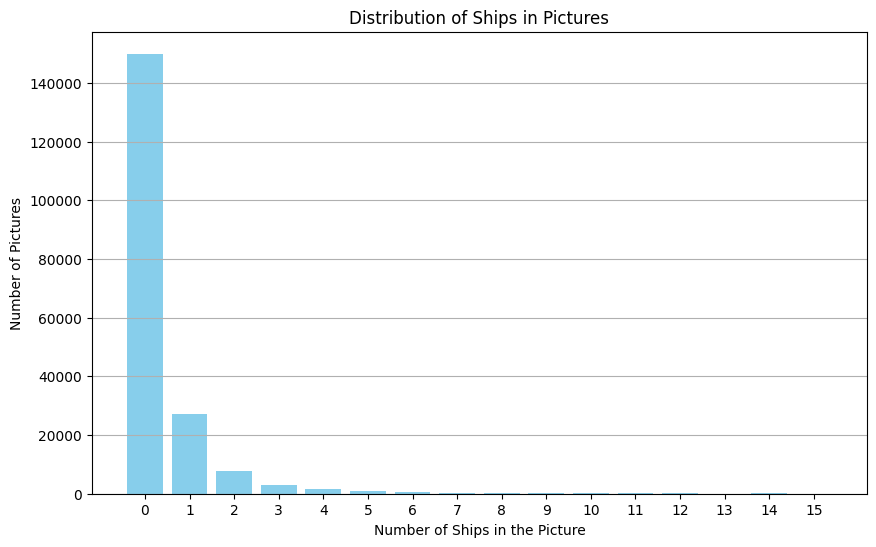

The picture with the most ships is '01914baf2.jpg' with 15 ships.


In [ ]:
# Set path to the .csv file containig the output rle-s
csv_path = '/content/train_ship_segmentations_v2.csv'

# Functio to count how many ships does each picture contains
def count_ships(csv_path):
    df = pd.read_csv(csv_path, header=None, skiprows=1)

    # Create a dictionary to count ships per filename
    ship_count = {}

    # Iterate through the DataFrame
    for index, row in df.iterrows():
        filename = row[0]  # Picture filename
        rle = row[1]  # RLE encoded map

        # Only process if the filename is a string and is not NaN
        if isinstance(filename, str) and filename.strip():
            if filename not in ship_count:
                ship_count[filename] = 0  # Initialize count for the filename

            # If RLE is not empty (and is a string), increment the ship count for this filename
            if isinstance(rle, str) and rle.strip():  # If there is an RLE code, it means there is at least one ship
                ship_count[filename] += 1  # Increment ship count

    # Count how many pictures have 0, 1, 2, etc. ships
    ship_distribution = {}
    for count in ship_count.values():
        if count not in ship_distribution:
            ship_distribution[count] = 0
        ship_distribution[count] += 1  # Count the occurrences of each ship count

    return ship_count, ship_distribution  # Return both dictionaries

def plot_ship_distribution(ship_distribution):
    # Prepare data for plotting
    counts = list(ship_distribution.keys())
    num_pictures = list(ship_distribution.values())

    # Create a histogram
    plt.figure(figsize=(10, 6))
    plt.bar(counts, num_pictures, color='skyblue')
    plt.xlabel('Number of Ships in the Picture')
    plt.ylabel('Number of Pictures')
    plt.title('Distribution of Ships in Pictures')
    plt.xticks(counts)  # Set x-ticks to be the counts
    plt.grid(axis='y')
    plt.show()

# Function to find the picture with the maximum number of ships
def find_max_ships_picture(ship_count):
    max_ships = -1
    max_picture = None

    for filename, count in ship_count.items():
        if count > max_ships:
            max_ships = count
            max_picture = filename

    return max_picture, max_ships

# Count ships and plot the distribution
ship_count, ship_distribution = count_ships(csv_path)
plot_ship_distribution(ship_distribution)

max_picture, max_ships = find_max_ships_picture(ship_count)

print(f"The picture with the most ships is '{max_picture}' with {max_ships} ships.")


In [ ]:
# Load the .csv file, skipping the first row
df = pd.read_csv('/content/train_ship_segmentations_v2.csv', skiprows=1, header=None, names=['filename', 'rle_data'])

# Convert RLE data to string, replacing NaN with an empty string
df['rle_data'] = df['rle_data'].astype(str).replace('nan', '')

# Group by filename and combine the RLE data, so that every picture only has one RLE output containing all the information
combined_df = df.groupby('filename')['rle_data'].apply(lambda x: ' '.join(x)).reset_index()

# Save the combined data to a new CSV file
combined_df.to_csv('combined_rle_data.csv', index=False)


##This segment creates the output images from the rle data in the .csv file

In [ ]:
csv_path = '/content/combined_rle_data.csv'
output_folder = '/content/rle_images'
os.makedirs(output_folder, exist_ok=True)

# Function to decode the rle codes for output data visualization
def rle_decode(rle, height, width):
    # Decodes the RLE encoded string into a binary mask (image) filled column by column.
    rle = list(map(int, rle.split()))
    img = np.zeros((height, width), dtype=np.uint8)  # Create an empty 2D array

    for start, length in zip(rle[::2], rle[1::2]):
        # Calculate column and row based on column-major order
        col_start = start // height  # Column index
        row_start = start % height    # Row index within that column

        for i in range(length):
            # Fill the pixel in column-major order
            img[(row_start + i) % height, col_start] = 255  # Update the corresponding pixel

    return img

# Creates the output images from the rle data
def process_rle_images(csv_path, output_folder):
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    with open(csv_path, 'r') as file:
        # Skip the first row (header)
        next(file)

        # Process each line in the CSV
        for line in file:
            # Strip whitespace and split by comma
            parts = line.strip().split(',')
            if len(parts) != 2:
                print(f"Skipping invalid line: {line.strip()}")
                continue  # Skip invalid lines

            filename, rle = parts
            filename = filename.strip()
            rle = rle.strip()

            # Decode the RLE into a 768x768 image
            img_data = rle_decode(rle, height=768, width=768)

            # Create an image from the array
            img = Image.fromarray(img_data, mode='L')  # 'L' mode for grayscale

            img.save(os.path.join(output_folder, filename))

# Process the images from RLE
process_rle_images(csv_path, output_folder)

In [ ]:
# Set path to the .csv file containig the output rle-s
csv_path = '/content/train_ship_segmentations_v2.csv'

df = pd.read_csv(csv_path, header=None, skiprows=1)

# Initialize a dictionary to hold counts
ship_count = {}

# Iterate through each picture
for index, row in df.iterrows():
    filename = row[0]  # Picture filename
    rle = row[1]  # RLE encoded map

    # Only process if the filename is a string and is not NaN
    if isinstance(filename, str) and filename.strip():
        if filename not in ship_count:
            ship_count[filename] = {'count': 0, 'has_rle': False}

        # Count occurrences
        ship_count[filename]['count'] += 1

        # Check if there is an RLE code (indicating a ship is present)
        if isinstance(rle, str) and rle.strip():  # If there is an RLE code
            ship_count[filename]['has_rle'] = True

# Finalize the ship counts based on occurrences and presence of RLE
final_ship_count = {filename: (data['count'] if data['has_rle'] else 0) for filename, data in ship_count.items()}

dir1 = '/content/rle_images'
dir2 = '/content/train_v2'

# List of files in both directories
files_dir1 = set(os.listdir(dir1))
files_dir2 = set(os.listdir(dir2))

# Find the common files between the two directories
common_files = files_dir1.intersection(files_dir2)

# Create a list to store the image pairs and counts
image_pairs = []
total_pairs_found = 0  # Initialize a counter for pairs found

# Create pairs of images with ship count
for file_name in common_files:
    count = final_ship_count.get(file_name, 0)  # Get the count, default to 0 if not found
    image_pairs.append((file_name, count))
    total_pairs_found += 1  # Increment the counter for each pair found

# Print the total number of pairs found
print(f"\nTotal Pairs Found: {total_pairs_found}")



Total Pairs Found: 192556


###This segment will seperate the pictures into two different arrays, based on wether they contain ships or not.

In [ ]:
def separate_filenames_by_ship_count(image_pairs):
    # Initialize arrays for images with and without ships
    images_with_ships = []
    images_without_ships = []

    # Separate images based on ship count
    for filename, count in image_pairs:
        if count > 0:
            images_with_ships.append((filename, count))  # Append to images with ships
        else:
            images_without_ships.append((filename, count))  # Append to images without ships

    return images_with_ships, images_without_ships

# Call the function
with_ships, without_ships = separate_filenames_by_ship_count(image_pairs)

# Output the results
print("Images with ships:", len(with_ships))
print("Images without ships:", len(without_ships))


Images with ships: 42556
Images without ships: 150000


The following code will show 5 samples of how the mask looks like after decoding it into 768x768 pictures. The purple color masked over the original picture is the RLE encoded pixels of the mask. If for some reason the picture loading fails the program will give an error message. (Running this code segment multiple times is enabled, it will just show 5 other pictures as samples)

Note: The samples shown are only selected from pictures that contain at least one ship

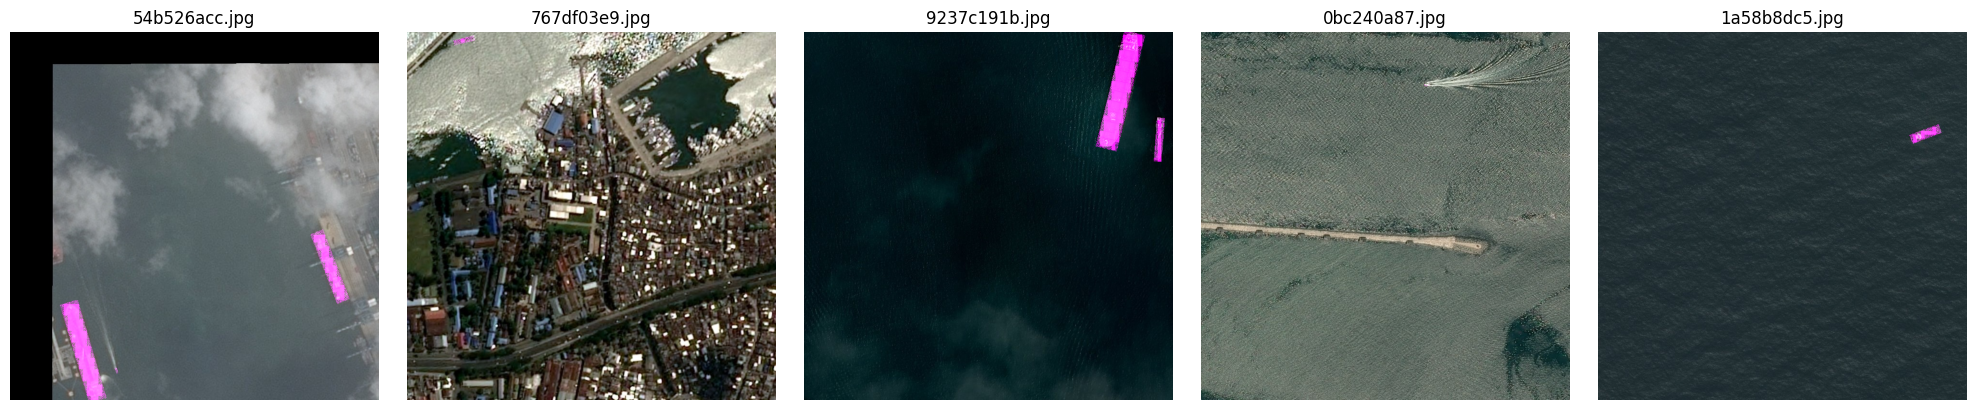

In [ ]:
# Directories containing the images
dir_original = '/content/train_v2'  # Path to the original images
dir_rle = '/content/rle_images'       # Path to the RLE images

# Check if with_ships is a NumPy array
if isinstance(with_ships, np.ndarray):
    # Choose 5 random elements from the first column of the array
    selected_images = random.sample(list(with_ships[:, 0]), 5)  # Extract only the first column for filenames
else:
    # Assuming with_ships is a list of lists or another iterable containing filenames in the first position
    selected_images = random.sample([entry[0] for entry in with_ships], 5)

# Prepare for plotting
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for i, image_name in enumerate(selected_images):
    # Step 2: Load the original and RLE images
    original_path = os.path.join(dir_original, f"{image_name}")
    rle_path = os.path.join(dir_rle, f"{image_name}")

    original_image = cv2.imread(original_path)
    rle_image = cv2.imread(rle_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale

    # Check if images are loaded correctly
    if original_image is None:
        print(f"Error loading original image: {original_path}")
        continue
    if rle_image is None:
        print(f"Error loading RLE image: {rle_path}")
        continue

    # Step 3: Create a binary mask
    binary_mask = (rle_image == 255).astype(np.uint8)  # 1 where white pixels, 0 where black pixels

    # Step 4: Create an RGB mask with the desired color (magenta)
    color_mask = np.zeros_like(original_image, dtype=np.uint8)
    color_mask[binary_mask == 1] = [255, 0, 255]  # Assign magenta color to white regions

    # Step 5: Apply the mask to the original image
    masked_image = cv2.addWeighted(original_image, 1, color_mask,1, 0)  # Blend the mask with the original image

    # Step 6: Plot the masked image
    axes[i].imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))
    axes[i].set_title(image_name)
    axes[i].axis('off')

plt.tight_layout()
plt.show()


In this code segment we wanted to make the dataset less assymetrical, because according to the histogram where we counted the number of ships on every picture, we could see that there are way more pictures without any, than there are with at least 1. There is a parameter in the beginning of the code that can change the amount of pictures with at least 1 ship, and the rest will be filled with randomly selected shipless pictures. (For example if the proportion is 0.7, it means that the main dataset will contain all the pictures with ships and it will fill 70% of the learning dataset, the remaining 30% is pictures without ships)

In [ ]:
!pip install keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.3 MB/s eta 0:00:00


In [ ]:
# !pip install keras-tuner  # Uncomment if Keras Tuner is not installed

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import keras_tuner as kt

import numpy as np
import cv2
import os
import random
import matplotlib.pyplot as plt

# Hyperparameters we will not tune here
IMAGE_SIZE = (384, 384)  # Input size for the model
BATCH_SIZE = 4
EPOCHS = 3
NUM_CLASSES = 2  # Background and ships

# ---------------------------
# 1) DATA PREPARATION
# ---------------------------

proportion = 0.7  # Data % with ships
prop_with_ships = 0.008
val_split = 0.15  # Proportion for validation
test_split = 0.0075  # Proportion for test

def merge_random_elements(with_ships, without_ships, proportion):  # Function to create the main dataset
    x_ship = int(len(with_ships) * prop_with_ships)
    # Notice this uses len(with_ships) for both with_ships and without_ships. If desired, adjust logic as needed.
    x_no_ship = int(len(with_ships) * (1 - proportion) * prop_with_ships)

    # Shuffle data
    random.shuffle(without_ships)
    random.shuffle(with_ships)

    # Select a subset
    selected_with_ships = with_ships[:x_ship]
    selected_without_ships = without_ships[:x_no_ship]
    main_data = selected_with_ships + selected_without_ships
    random.shuffle(main_data)

    return main_data

# Suppose you have two lists: with_ships, without_ships
# Each list contains tuples of (filename, label).
# We'll assume these lists are already defined somewhere above this cell.

main_data = merge_random_elements(with_ships, without_ships, proportion)

val_size = int(len(main_data) * val_split)
test_size = int(len(main_data) * test_split)

val_data = main_data[:val_size]
test_data = main_data[val_size : val_size + test_size]
train_data = main_data[val_size + test_size:]

# Quick checks
print(f"Train size: {len(train_data)}")
print(f"Validation size: {len(val_data)}")
print(f"Test size: {len(test_data)}")
print(f"Whith ships in train: {len([x for x in train_data if x[1] > 0])}")
print(f"Without ships in train: {len([x for x in train_data if x[1] == 0])}")


Train size: 373
Validation size: 66
Test size: 3
Whith ships in train: 282
Without ships in train: 91


In [ ]:
# ---------------------------
# 2) DATA GENERATOR
# ---------------------------
def data_generator(main_data, image_dir, mask_dir, batch_size=BATCH_SIZE):
    """
    A generator that yields (images, masks) batches.
    Each iteration:
        - Randomly samples 'batch_size' elements
        - Loads the corresponding images and binary masks
        - Resizes them to IMAGE_SIZE
        - Normalizes images and binarizes masks
    """
    while True:
        batch_data = random.sample(main_data, batch_size)
        images, masks = [], []

        for filename, _ in batch_data:
            img_path = os.path.join(image_dir, filename)
            mask_path = os.path.join(mask_dir, filename)

            # Load image and mask
            image = cv2.imread(img_path)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            # Check if images are loaded correctly
            if image is None:
                print(f"Error loading image: {img_path}")
                continue
            if mask is None:
                print(f"Error loading mask: {mask_path}")
                continue

            # Resize for uniformity
            image = cv2.resize(image, IMAGE_SIZE)
            mask = cv2.resize(mask, IMAGE_SIZE)

            # Normalize images and binary masks
            image = image.astype(np.float32) / 255.0
            mask = (mask > 0).astype(np.float32)  # Binary mask

            images.append(image)
            masks.append(mask)

        # Ensure that the batch is not empty
        if len(images) == 0:
            continue

        yield np.array(images), np.array(masks).reshape(-1, IMAGE_SIZE[0], IMAGE_SIZE[1], 1)

# ---------------------------
# 3) BACKBONE: RESNET50
# ---------------------------
def resnet50_backbone(input_shape):
    resnet50 = ResNet50(weights="imagenet", include_top=False, input_shape=input_shape)
    layer_names = ["conv2_block3_out", "conv3_block4_out", "conv4_block6_out"]
    outputs = [resnet50.get_layer(name).output for name in layer_names]
    return Model(inputs=resnet50.input, outputs=outputs)

def build_mask_head(roi_feature, filters=256, num_classes=1, activation='relu'):
    """
    A simple mask head to perform semantic segmentation output.
    'filters' and 'activation' are hyperparameters we might choose to tune.
    """
    # Initial convolution
    x = Conv2D(filters, (3, 3), padding="same", activation=activation)(roi_feature)

    # Deconvolution (Transpose Convolution) layers for upsampling
    x = Conv2DTranspose(filters, (3, 3), strides=(2, 2), padding="same", activation=activation)(x)
    x = Conv2DTranspose(filters, (3, 3), strides=(2, 2), padding="same", activation=activation)(x)
    x = Conv2DTranspose(filters, (3, 3), strides=(2, 2), padding="same", activation=activation)(x)
    x = Conv2DTranspose(filters, (3, 3), strides=(2, 2), padding="same", activation=activation)(x)

    # Final convolution to produce the mask output
    mask_output = Conv2D(num_classes, (1, 1), activation="sigmoid", name='mask_output')(x)
    return mask_output

def build_mask_rcnn(input_shape=(384, 384, 3), lr=1e-4, filters=256, num_classes=1, activation='relu'):
    """
    Build the Mask RCNN model (simplified to output only masks).
    Allows customization of learning rate, number of filters, and activation function in the mask head.
    """
    # Backbone
    input_img = Input(shape=input_shape, name='input_image')
    backbone = resnet50_backbone(input_shape)

    # Mask head
    roi_feature = backbone(input_img)[-1]  # Use last feature layer from backbone
    mask_output = build_mask_head(roi_feature, filters=filters, num_classes=num_classes, activation=activation)

    # Combine into Model
    model = Model(inputs=input_img, outputs=mask_output, name='Mask_RCNN_Simplified')

    return model

# Print summary of a "default" model
test_model = build_mask_rcnn()
test_model.summary()


Model: "Mask_RCNN_Simplified"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 384, 384, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_1 (Functional)            │ [(None, 96, 96, 256),       │       8,589,184 │
│                                      │ (None, 48, 48, 512), (None, │                 │
│                                      │ 24, 24, 1024)]              │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 24, 24, 256)         │       2,359,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 48, 48, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_5 (Conv2DTranspose) │ (None, 96, 96, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_6 (Conv2DTranspose) │ (None, 192, 192, 256)       │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_7 (Conv2DTranspose) │ (None, 384, 384, 256)       │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mask_output (Conv2D)                 │ (None, 384, 384, 1)         │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,309,313 (50.77 MB)

 Trainable params: 13,278,721 (50.65 MB)

 Non-trainable params: 30,592 (119.50 KB)

In [ ]:
# ---------------------------
# 4) HYPERPARAMETER TUNING
# ---------------------------
def build_tune_model(hp):
    """
    Keras Tuner HyperModel function that builds and returns a compiled model
    with specified hyperparameters.
    """
    # Hyperparameters to tune
    lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])  # Example set
    filters = hp.Choice('mask_head_filters', values=[128, 256, 512])
    activation = hp.Choice('activation', values=['relu', 'elu', 'tanh'])
    optimizer_choice = hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop'])

    # Build model with the chosen activation
    model = build_mask_rcnn(
        input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
        lr=lr,
        filters=filters,
        num_classes=1
    )

    # Compile with the chosen optimizer
    optimizer = {
        'adam': tf.keras.optimizers.Adam(learning_rate=lr),
        'sgd': tf.keras.optimizers.SGD(learning_rate=lr),
        'rmsprop': tf.keras.optimizers.RMSprop(learning_rate=lr)
    }[optimizer_choice]

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Instantiate a Keras Tuner, e.g. RandomSearch
tuner = kt.RandomSearch(
    hypermodel=build_tune_model,
    objective='val_loss',   # or 'val_accuracy'
    max_trials=100,           # number of hyperparameter configurations to try
    executions_per_trial=1, # number of models to build and evaluate for each trial
    overwrite=True,         # overwrite old search results
    directory='tuner_results',
    project_name='mask_rcnn'
)

# Print a summary of the search space
tuner.search_space_summary()

# Prepare data generators for training and validation
image_dir = '/content/train_v2'
mask_dir = '/content/rle_images'

train_gen = data_generator(train_data, image_dir, mask_dir)
val_gen = data_generator(val_data, image_dir, mask_dir)

# Calculate steps per epoch
train_steps_per_epoch = max(len(train_data) // BATCH_SIZE, 1)
val_steps_per_epoch = max(len(val_data) // BATCH_SIZE, 1)

# Define callbacks (could re-use your existing ones)
checkpoint = ModelCheckpoint('mask_rcnn_best_model.keras', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Run hyperparameter search
tuner.search(
    train_gen,
    epochs=EPOCHS,
    steps_per_epoch=train_steps_per_epoch,
    validation_data=val_gen,
    validation_steps=val_steps_per_epoch,
    callbacks=[checkpoint, early_stopping],
    verbose=1
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:")
print(f"Learning rate: {best_hps.get('learning_rate')}")
print(f"Mask head filters: {best_hps.get('mask_head_filters')}")
print(f"Activation: {best_hps.get('activation')}")
print(f"Optimizer: {best_hps.get('optimizer')}")

# Build the best model
best_model = tuner.get_best_models(num_models=1)[0]

# (Optional) Retrain or Fine-tune the best model further if desired:
# best_model.fit(...)


Trial 5 Complete [00h 05m 01s]
val_loss: 0.04207649081945419

Best val_loss So Far: 0.021503036841750145
Total elapsed time: 00h 34m 22s
Best hyperparameters:
Learning rate: 0.01
Mask head filters: 128


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 370 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# ---------------------------
# 5) FINAL TRAIN & EVALUATION
# ---------------------------
best_model = tuner.get_best_models(num_models=1)[0]
# Re-initialize data generators in case they have been consumed
train_gen = data_generator(train_data, image_dir, mask_dir)
val_gen = data_generator(val_data, image_dir, mask_dir)

# Calculate steps per epoch again
train_steps_per_epoch = max(len(train_data) // BATCH_SIZE, 1)
val_steps_per_epoch = max(len(val_data) // BATCH_SIZE, 1)

# We can do a final training run with the best model
history = best_model.fit(
    train_gen,
    steps_per_epoch=train_steps_per_epoch,
    epochs=EPOCHS,
    validation_data=val_gen,
    validation_steps=val_steps_per_epoch,
    callbacks=[checkpoint, early_stopping],
    verbose=1
)

# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

# Evaluate on the test dataset
test_gen = data_generator(test_data, image_dir, mask_dir, batch_size=len(test_data))  # Single batch for testing
test_images, test_masks = next(test_gen)
test_loss, test_accuracy = best_model.evaluate(test_images, test_masks, verbose=1)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


NameError: name 'tuner' is not defined

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


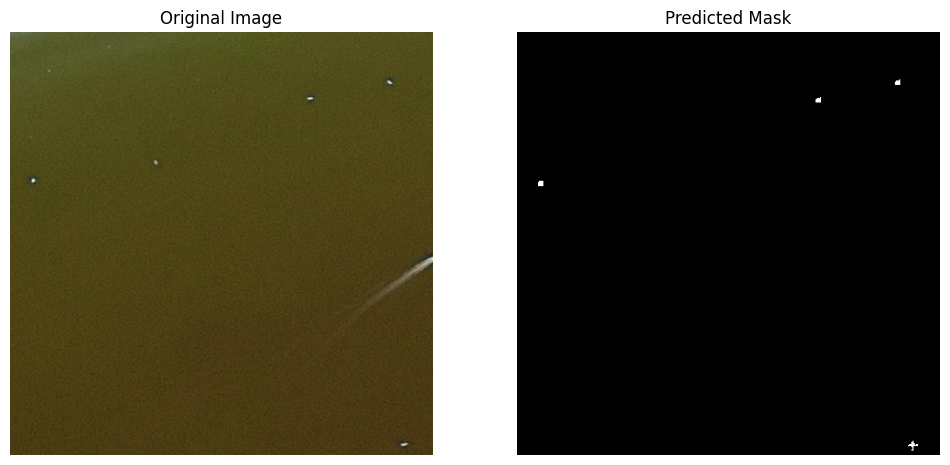

In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Load the saved model
model = tf.keras.models.load_model('mask_rcnn_best_model.keras')

# Step 2: Load and preprocess the input image
image_path = 'test_v2/018d23aea.jpg'  # Replace with your image path
image = cv2.imread(image_path)

# Resize the image to the input shape the model expects
image_resized = cv2.resize(image, (384, 384))  # Assuming your model takes (768, 768) images

# Normalize the image (same normalization as during training)
image_resized = image_resized.astype(np.float32) / 255.0

# Expand dimensions to add a batch axis
image_input = np.expand_dims(image_resized, axis=0)

# Step 3: Make prediction
predictions = model.predict(image_input)

# Step 4: Post-process predictions (for example, converting the mask output back to an image)
mask = predictions[0]  # Assuming the model outputs a mask
mask = (mask > 0.5).astype(np.uint8)  # Convert to binary mask if using sigmoid

# Step 5: Plot the original image and the predicted mask using plt
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the original image
axes[0].imshow(image_resized)
axes[0].set_title("Original Image")
axes[0].axis('off')

# Plot the predicted mask
axes[1].imshow(mask, cmap='gray')
axes[1].set_title("Predicted Mask")
axes[1].axis('off')

plt.show()
